<a href="https://colab.research.google.com/github/muajnstu/DSK-Chain-to-predict-diabeties-/blob/main/AUROC_for_refined_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
def print_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    num_classes = cm.shape[0]

    if num_classes == 2:
        TN, FP, FN, TP = cm.ravel()
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        gmean = np.sqrt(specificity * sensitivity)
        type1 = FP / (FP + TN) if (FP + TN) > 0 else 0
        type2 = FN / (TP + FN) if (TP + FN) > 0 else 0
        fmeasure = f1_score(y_true, y_pred, pos_label=1)
        auc_score = 0
        if y_prob is not None and hasattr(y_prob, "shape") and y_prob.shape[1] > 1:
            try:
                auc_score = roc_auc_score(y_true, y_prob[:, 1])
            except Exception:
                auc_score = 0
    else:
        TP = np.diag(cm)
        FP = np.sum(cm, axis=0) - TP
        FN = np.sum(cm, axis=1) - TP
        TN = np.sum(cm) - (FP + FN + TP)
        specificity = np.mean([
            TN[i] / (TN[i] + FP[i]) if (TN[i] + FP[i]) > 0 else 0 for i in range(num_classes)
        ])
        sensitivity = np.mean([
            TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)
        ])
        gmean = np.sqrt(specificity * sensitivity)
        type1 = np.mean([
            FP[i] / (FP[i] + TN[i]) if (FP[i] + TN[i]) > 0 else 0 for i in range(num_classes)
        ])
        type2 = np.mean([
            FN[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)
        ])
        fmeasure = f1_score(y_true, y_pred, average='macro')
        auc_score = 0
        if y_prob is not None and hasattr(y_prob, "shape") and y_prob.shape[1] > 1:
            try:
                auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
            except Exception:
                auc_score = 0

    print(f"Accuracy      : {accuracy:.4f}")
    print(f"Sensitivity   : {sensitivity:.4f}")
    print(f"Specificity   : {specificity:.4f}")
    print(f"G-Mean        : {gmean:.4f}")
    print(f"Type I Error  : {type1:.4f}")
    print(f"Type II Error : {type2:.4f}")
    print(f"F1 Score      : {fmeasure:.4f}")
    print(f"AUROC         : {auc_score:.4f}")


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/filtered_df.csv')
X = df.drop(columns=['Cluster'])
y = df['Cluster']

# Handle Imbalanced Data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=46, stratify=y_resampled
)

In [ ]:
# Recalculate covariance and variance with the current X_train after SMOTE
covariance_matrix = np.cov(X_train.T)
stabilized_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
inv_covariance_matrix = np.linalg.inv(stabilized_covariance_matrix)
variance_vector = np.var(X_train, axis=0)

# KNN Variant Definitions
knn_variants = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "D-KNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "G-KNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3),
    "E-KNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "MT-KNN": KNeighborsClassifier(n_neighbors=3, metric='manhattan'),
    "C-KNN": KNeighborsClassifier(n_neighbors=3, metric='chebyshev'),
    "ML-KNN": KNeighborsClassifier(n_neighbors=3, metric='mahalanobis', metric_params={'VI': inv_covariance_matrix}),
    "S-KNN": KNeighborsClassifier(n_neighbors=3, metric='seuclidean', metric_params={'V': variance_vector}),
    "W-KNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3, metric_params={'w': np.ones(X_train.shape[1])})
}

# Evaluate KNN Variants
def run_knn_variant(name, knn_clf):
    print(f"\n==== {name} ====")
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    if hasattr(knn_clf, "predict_proba"):
        try:
            y_prob = knn_clf.predict_proba(X_test)
        except Exception:
            y_prob = None
    else:
        y_prob = None
    print_metrics(y_test, y_pred, y_prob)

for name, model in knn_variants.items():
    run_knn_variant(name, model)



==== KNN ====
Accuracy      : 0.9217
Sensitivity   : 0.9217
Specificity   : 0.9608
G-Mean        : 0.9411
Type I Error  : 0.0392
Type II Error : 0.0783
F1 Score      : 0.9205
AUROC         : 0.9648

==== D-KNN ====
Accuracy      : 0.9276
Sensitivity   : 0.9276
Specificity   : 0.9638
G-Mean        : 0.9455
Type I Error  : 0.0362
Type II Error : 0.0724
F1 Score      : 0.9264
AUROC         : 0.9667

==== G-KNN ====
Accuracy      : 0.9268
Sensitivity   : 0.9268
Specificity   : 0.9634
G-Mean        : 0.9449
Type I Error  : 0.0366
Type II Error : 0.0732
F1 Score      : 0.9260
AUROC         : 0.9673

==== E-KNN ====
Accuracy      : 0.9217
Sensitivity   : 0.9217
Specificity   : 0.9608
G-Mean        : 0.9411
Type I Error  : 0.0392
Type II Error : 0.0783
F1 Score      : 0.9205
AUROC         : 0.9648

==== MT-KNN ====
Accuracy      : 0.8881
Sensitivity   : 0.8881
Specificity   : 0.9440
G-Mean        : 0.9156
Type I Error  : 0.0560
Type II Error : 0.1119
F1 Score      : 0.8843
AUROC         : 0.9

Refined DSK-chain

In [ ]:
estimators = [(name, model) for name, model in knn_variants.items()]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    passthrough=False,
    cv=10
)
print("\n==== Stacking Ensemble 3 ====")
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
try:
    y_prob_stacking = stacking_clf.predict_proba(X_test)
except Exception:
    y_prob_stacking = None
print_metrics(y_test, y_pred_stacking, y_prob_stacking)



==== Stacking Ensemble 3 ====


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: SyntaxWarning: Parameter p is found in metric_params. The 

Accuracy      : 0.9798
Sensitivity   : 0.9798
Specificity   : 0.9899
G-Mean        : 0.9849
Type I Error  : 0.0101
Type II Error : 0.0202
F1 Score      : 0.9797
AUROC         : 0.9903


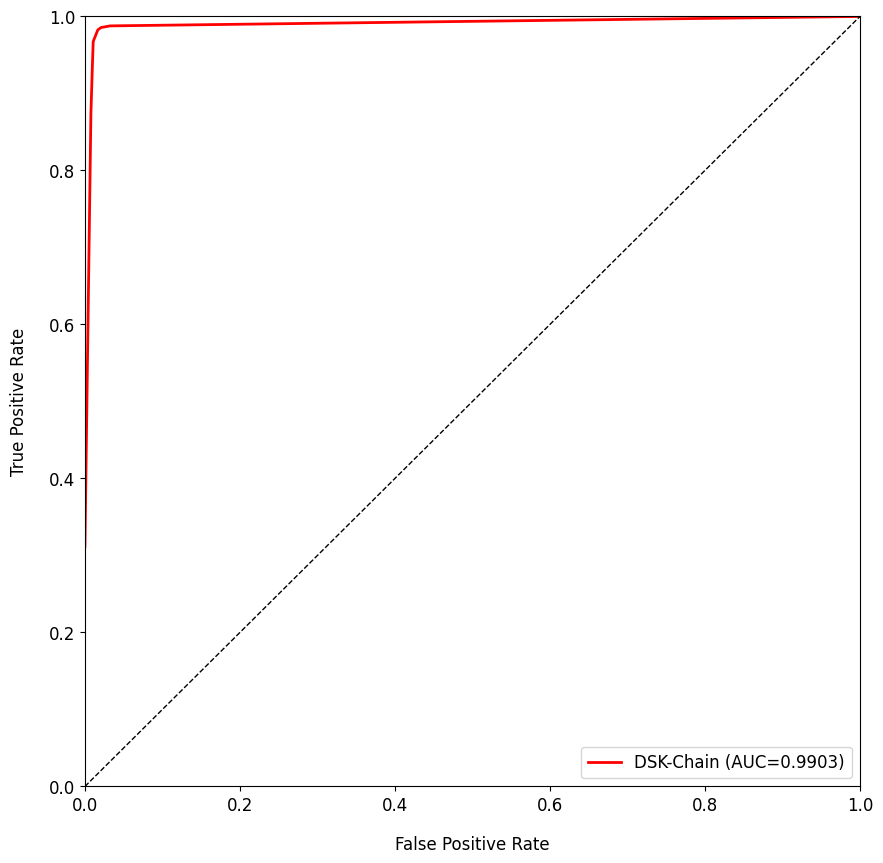

In [ ]:
if y_prob_stacking is not None:
    y_test_bin = label_binarize(y_test, classes=stacking_clf.classes_)
    n_classes = y_prob_stacking.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_stacking[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    macro_auc = auc(all_fpr, mean_tpr)


    plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
    })

    plt.figure(figsize=(10, 10))
    plt.plot(all_fpr, mean_tpr, color='red', lw=2,
             label=f'DSK-Chain (AUC={macro_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', labelpad=15)
    plt.ylabel('True Positive Rate', labelpad=15)
    plt.legend(loc="lower right")
    plt.show()